<img src=https://upload.wikimedia.org/wikipedia/commons/6/68/Logo_universidad_icesi.svg width=300>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sebastianb92/nlp-labs/blob/main/Session1/2-Sentiment-Analysis.ipynb)


# Maestría en Inteligencia Artificial  
## Procesamiento de Lenguaje natural
### Sesión 2 - Práctica

---


**Integrantes:**  
- Johan Sebastian Bonilla  
- Edwin Gómez  

# Introducción

Este notebook explora el análisis de conversaciones políticas en WhatsApp utilizando técnicas de procesamiento de lenguaje natural (PLN). A través de la limpieza, tokenización, lematización y análisis de frecuencia de palabras, se identifican los temas y posturas predominantes entre los participantes. Además, se aplica análisis de sentimientos, comparando enfoques en español e inglés, para evaluar la polarización y el tono de la discusión. El objetivo es ilustrar cómo el PLN puede revelar dinámicas y patrones en debates políticos reales.

# Configurar entorno

En esta sección se configuran las librerías y dependencias necesarias para el análisis de datos y procesamiento de lenguaje natural. Esto garantiza que el entorno esté listo para cargar, limpiar y analizar las conversaciones del chat político.

In [1]:
import sys
import warnings

warnings.filterwarnings('ignore')

# Detectar si estamos en Google Colab
IN_COLAB = 'google.colab' in sys.modules

In [2]:
if IN_COLAB:
    !wget https://raw.githubusercontent.com/sebastianb92/nlp-labs/refs/heads/main/requirements.txt && pip install -r requirements.txt
    !python -m spacy download es_core_news_sm
else:
    !pip3 install -r ../requirements.txt

--2026-02-22 18:26:45--  https://raw.githubusercontent.com/sebastianb92/nlp-labs/refs/heads/main/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 274 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     274  --.-KB/s    in 0s      

2026-02-22 18:26:45 (4.66 MB/s) - ‘requirements.txt’ saved [274/274]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 22.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab no

In [3]:
!test '{IN_COLAB}' = 'True' && wget https://raw.githubusercontent.com/sebastianb92/nlp-labs/refs/heads/feature/session1/sentiment-analysis/Session1/political_analysis.txt

--2026-02-22 18:27:18--  https://raw.githubusercontent.com/sebastianb92/nlp-labs/refs/heads/feature/session1/sentiment-analysis/Session1/political_analysis.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18844 (18K) [text/plain]
Saving to: ‘political_analysis.txt’

political_analysis. 100%[===================>]  18.40K  --.-KB/s    in 0s      

2026-02-22 18:27:19 (146 MB/s) - ‘political_analysis.txt’ saved [18844/18844]



In [4]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from transformers import pipeline

In [5]:
with open('political_analysis.txt', 'r', encoding='utf-8') as file:
    content = file.read()

# Patrón regex para capturar el formato: [HH:MM AM/PM, MM/DD/YYYY] Nombre: Mensaje
pattern = r'\[(\d{1,2}:\d{2}\s[AP]M),\s(\d{1,2}/\d{1,2}/\d{4})\]\s(\w+):\s'

# Encontrar todas las coincidencias con sus posiciones
matches = list(re.finditer(pattern, content))

# Extraer datos
data = []
for i, match in enumerate(matches):
    time = match.group(1)
    date = match.group(2)
    name = match.group(3)

    # Obtener contenido del mensaje (desde el fin del match actual hasta el inicio del siguiente o fin del archivo)
    start_pos = match.end()
    end_pos = matches[i + 1].start() if i + 1 < len(matches) else len(content)
    message = content[start_pos:end_pos].strip()

    data.append({
        'time': time,
        'date': date,
        'name': name,
        'message': message
    })

# Crear DataFrame
df = pd.DataFrame(data)

# Mostrar el dataset
print(f"Total de mensajes: {len(df)}")
print(f"Participantes: {df['name'].unique()}")
df.head(10)

Total de mensajes: 84
Participantes: ['Pedro' 'María' 'Fernando' 'Carlos' 'Nelson' 'Patricio']


,time,date,name,message
0,11:24 AM,2/17/2026,Pedro,Que par de Joyitas son Petro y el ministro de ...
1,11:24 AM,2/17/2026,Pedro,Son unos Barbaros
2,11:29 AM,2/17/2026,Pedro,Que lo diga alguien que votó y celebró el triu...
3,11:39 AM,2/17/2026,María,Me encantan las fuentes de documentación de lo...
4,11:40 AM,2/17/2026,Fernando,"Que lo diga petro , pero que lo diga el minist..."
5,11:44 AM,2/17/2026,Pedro,El duo de la Muerte culparon a la Señora Madre...
6,11:44 AM,2/17/2026,Pedro,"Pues el no murió por la caida en Bicicleta, Mu..."
7,11:45 AM,2/17/2026,Pedro,"Kevin, un niño de 7 años"
8,11:45 AM,2/17/2026,Pedro,"No son fuentes de documentación y pacotilla, s..."
9,11:59 AM,2/17/2026,María,"querido Pedro, la indignación debería sentirla..."


In [6]:
import nltk
import spacy

nltk.download('stopwords')  #Son palabras que aportan poco significado al análisis
nltk.download('punkt')      #Tokenizadores: identifican frases con base en patrones: puntuación, abreviaciones, mayúsculas.
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist

# Cargar modelo de spaCy en español para lemmatización
nlp = spacy.load('es_core_news_sm')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# Tokenización y análisis de frecuencia

En esta sección se realiza la tokenización de los mensajes del chat, permitiendo analizar la frecuencia de palabras y detectar los términos más utilizados. Este proceso es fundamental para identificar los temas predominantes y el enfoque de la conversación.

In [7]:
# Tokenizar y filtrar todos los mensajes
all_words = []
for msg in df['message']:
    tokens = word_tokenize(msg.lower())
    filtered = [w for w in tokens if w.isalpha()]
    all_words.extend(filtered)

# Análisis de frecuencia de palabras
freq_dist = FreqDist(all_words)
freq_dist.most_common(30)

[('de', 142),
 ('que', 120),
 ('y', 74),
 ('el', 74),
 ('la', 69),
 ('no', 63),
 ('en', 55),
 ('por', 50),
 ('es', 45),
 ('a', 45),
 ('un', 43),
 ('lo', 42),
 ('se', 35),
 ('los', 31),
 ('para', 29),
 ('si', 20),
 ('eso', 20),
 ('del', 19),
 ('con', 18),
 ('este', 18),
 ('las', 17),
 ('pero', 17),
 ('una', 17),
 ('como', 16),
 ('gobierno', 15),
 ('porque', 15),
 ('millones', 14),
 ('le', 13),
 ('petro', 12),
 ('más', 12)]

Eliminamos "stopwords": palabras irrelevantes para el análisis (combinadas desde NLTK y Spacy)

In [8]:
# Obtener stopwords en español
from nltk.corpus import stopwords
from spacy.lang.es.stop_words import STOP_WORDS as spacy_stopwords

stop_words = set(stopwords.words('spanish')) | set(spacy_stopwords)

print(stop_words)

{'hubisteis', 'tuviese', 'hubiéramos', 'hayan', 'nuestros', 'tras', 'última', 'solamente', 'mediante', 'voy', 'ningún', 'a', 'hacemos', 'vuestra', 'cómo', 'alguna', 'ocho', 'tercera', 'del', 'haya', 'fuisteis', 'partir', 'tienes', 'nosotros', 'encima', 'contra', 'serás', 'hace', 'ésas', 'fueron', 'podría', 'fuiste', 'mio', 'dieron', 'vuestros', 'hubiste', 'estaréis', 'nuevas', 'estuvieron', 'apenas', 'siendo', 'todos', 'conseguir', 'vamos', 'sería', 'conmigo', 'tuve', 'realizar', 'fuerais', 'tu', 'tanto', 'aqui', 'cuantas', 'algo', 'habré', 'ciertas', 'debido', 'los', 'medio', 'sentida', 'os', 'veces', 'tengas', 'arriba', 'serán', 'mayor', 'otra', 'casi', 'mientras', 'través', 'saber', 'mis', 'aquél', 'podrían', 'cualquier', 'habíamos', 'fueses', 'han', 'yo', 'estaré', 'esas', 'primero', 'parte', 'hasta', 'te', 'erais', 'de', 'fueran', 'solas', 'considera', 'habla', 'respecto', 'sigue', 'usamos', 'tan', 'pueden', 'deprisa', 'más', 'ella', 'las', 'son', 'día', 'alrededor', 'habia', 'ter

In [9]:
# Tokenizar y filtrar todos los mensajes
all_words = []
for msg in df['message']:
    tokens = word_tokenize(msg.lower())
    filtered = [w for w in tokens if w.isalpha() and w not in stop_words]
    all_words.extend(filtered)

# Análisis de frecuencia de palabras
freq_dist = FreqDist(all_words)
freq_dist.most_common(20)

[('gobierno', 15),
 ('millones', 14),
 ('petro', 12),
 ('fotógrafo', 12),
 ('fuentes', 10),
 ('rtvc', 10),
 ('https', 9),
 ('maquillador', 7),
 ('semana', 7),
 ('ignorancia', 7),
 ('meses', 6),
 ('gobiernos', 6),
 ('caso', 6),
 ('colombia', 6),
 ('ministro', 5),
 ('diga', 5),
 ('kevin', 5),
 ('carlos', 5),
 ('noticia', 5),
 ('comentario', 5)]

In [11]:
# Patrón para detectar URLs
url_pattern = re.compile(r'https?://\S+|www\.\S+')

In [12]:
# Tokenizar y filtrar todos los mensajes (excluyendo URLs)
all_words = []
for msg in df['message']:
    # Eliminar URLs antes de tokenizar
    msg_clean = url_pattern.sub('', msg.lower())
    tokens = word_tokenize(msg_clean)
    filtered = [w for w in tokens if w.isalpha() and w not in stop_words]
    all_words.extend(filtered)

# Análisis de frecuencia de palabras
freq_dist = FreqDist(all_words)
freq_dist.most_common(30)

[('gobierno', 15),
 ('millones', 14),
 ('petro', 12),
 ('fotógrafo', 12),
 ('fuentes', 10),
 ('rtvc', 10),
 ('maquillador', 7),
 ('semana', 7),
 ('ignorancia', 7),
 ('meses', 6),
 ('gobiernos', 6),
 ('caso', 6),
 ('colombia', 6),
 ('ministro', 5),
 ('diga', 5),
 ('kevin', 5),
 ('carlos', 5),
 ('noticia', 5),
 ('comentario', 5),
 ('cooperativa', 5),
 ('administración', 5),
 ('delegada', 5),
 ('contrato', 5),
 ('comercial', 5),
 ('pib', 5),
 ('presidente', 5),
 ('falsa', 5),
 ('persona', 5),
 ('ayer', 5),
 ('salud', 4)]

# Lemmatización: lemmas más frecuentes

La lemmatización permite agrupar variantes de una misma palabra bajo su forma canónica (lemma), mejorando significativamente el análisis de frecuencia. Por ejemplo:
- "gobiernos", "gobierno", "gubernamental" → **gobierno**
- "dijo", "dice", "diga", "decir" → **decir**
- "millones", "millón" → **millón**

Esto reduce el ruido y revela mejor los temas centrales de la conversación.

In [13]:
# Función para obtener lemmas de un texto
def get_lemmas(text):
    """Extrae los lemmas de un texto usando spaCy, excluyendo URLs"""
    # Eliminar URLs antes de procesar
    text_clean = url_pattern.sub('', text.lower())
    doc = nlp(text_clean)
    lemmas = [token.lemma_ for token in doc if token.is_alpha and token.lemma_ not in stop_words]
    return lemmas

# Tokenizar, lematizar y filtrar todos los mensajes
all_lemmas = []
for msg in df['message']:
    lemmas = get_lemmas(msg)
    all_lemmas.extend(lemmas)

# Análisis de frecuencia con lematización
freq_dist = FreqDist(all_lemmas)
print("Top 20 lemmas más frecuentes:")
freq_dist.most_common(20)

Top 20 lemmas más frecuentes:


[('gobierno', 21),
 ('fuente', 14),
 ('millón', 14),
 ('petro', 12),
 ('fotógrafo', 12),
 ('falso', 11),
 ('rtvc', 10),
 ('contrato', 9),
 ('objetivo', 9),
 ('persona', 8),
 ('noticia', 8),
 ('maquillador', 7),
 ('ignorancia', 7),
 ('mes', 6),
 ('caso', 6),
 ('colombia', 6),
 ('comentario', 6),
 ('pasar', 6),
 ('ministro', 5),
 ('kevin', 5)]

Esta es la lista de las palabras más relevantes extraídas de los mensajes del chat: refleja los temas centrales de la conversación, como política, gobierno, economía y controversias, permitiendo identificar tendencias y palabras clave entre los participantes.

# Frecuencia de palabras por participante

En esta sección se presentan las palabras más frecuentes utilizadas por cada participante en el chat. Este análisis permite identificar los temas y enfoques predominantes de cada persona, revelando diferencias en intereses, posturas y estilos de comunicación dentro de la conversación política.

In [14]:
for participant in df['name'].unique():
    participant_messages = df[df['name'] == participant]['message'].str.cat(sep=' ')
    # Eliminar URLs antes de tokenizar
    participant_messages_clean = url_pattern.sub('', participant_messages.lower())
    tokens = word_tokenize(participant_messages_clean)
    filtered_words = [w for w in tokens if w.isalpha() and w not in stop_words]
    freq_dist_participant = FreqDist(filtered_words)
    print(f"\nTop 5 palabras más frecuentes para {participant}:")
    print(freq_dist_participant.most_common(5))


Top 5 palabras más frecuentes para Pedro:
[('ministro', 2), ('bicicleta', 2), ('murió', 2), ('par', 1), ('joyitas', 1)]

Top 5 palabras más frecuentes para María:
[('fuentes', 4), ('indignación', 3), ('millones', 3), ('querido', 2), ('debería', 2)]

Top 5 palabras más frecuentes para Fernando:
[('diga', 3), ('ocurría', 3), ('mario', 2), ('riñón', 2), ('gobiernos', 2)]

Top 5 palabras más frecuentes para Carlos:
[('gobierno', 9), ('millones', 8), ('fotógrafo', 6), ('petro', 5), ('maquillador', 4)]

Top 5 palabras más frecuentes para Nelson:
[('ignorancia', 5), ('bajeza', 3), ('colombia', 3), ('pib', 3), ('oportunismo', 2)]

Top 5 palabras más frecuentes para Patricio:
[('rtvc', 4), ('persona', 4), ('presidente', 4), ('gobierno', 3), ('noticia', 3)]


A partir de estos resultados, se hace evidente el énfasis que María y Patricio hacen sobre las fuentes de información y noticias, su expresión de indignación y búsqueda de argumentos, mostrando una postura más debatiente o crítica del enfoque de los demás. Fernando habla de casos individuales de salud (Mario, riñón), lo que sugiere que argumenta desde ejemplos reales. Carlos se enfoca claramente en la crítica política estructural (gobierno, millones, fotógrafo, maquillador), con fuerte énfasis en corrupción o gestión pública. Nelson usa términos más abstractos y valorativos (ignorancia, bajeza, oportunismo), indicando un discurso más ideológico o evaluativo.

A partir de estos resultados, adicionamos a la lista de stopwords palabras como "diga" y "ocurría" que no aportan significado para los análisis siguientes.

In [15]:
extra_stopwords = {'diga', 'ocurría'}
stop_words.update(extra_stopwords)

Palabras más comunes por participante

In [16]:
participant_top_words = {}

for participant in df['name'].unique():
    participant_messages = df[df['name'] == participant]['message'].str.cat(sep=' ')
    # Eliminar URLs antes de tokenizar
    participant_messages_clean = url_pattern.sub('', participant_messages.lower())
    tokens = word_tokenize(participant_messages_clean)
    filtered_words = [w for w in tokens if w.isalpha() and w not in stop_words]
    freq_dist_participant = FreqDist(filtered_words)
    participant_top_words[participant] = freq_dist_participant.most_common(5)

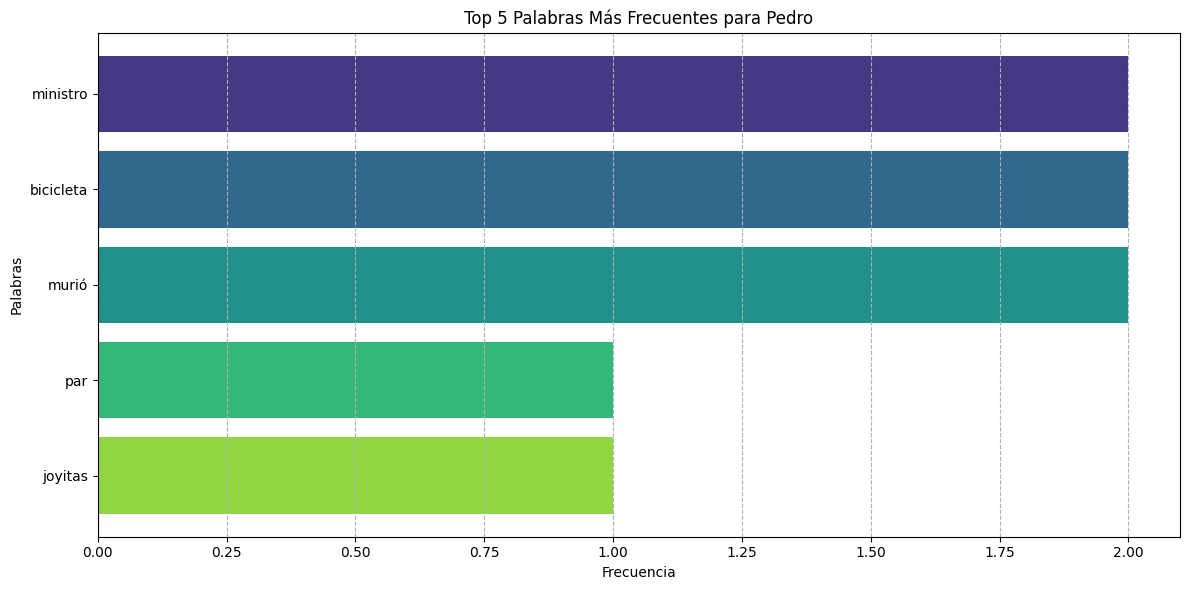

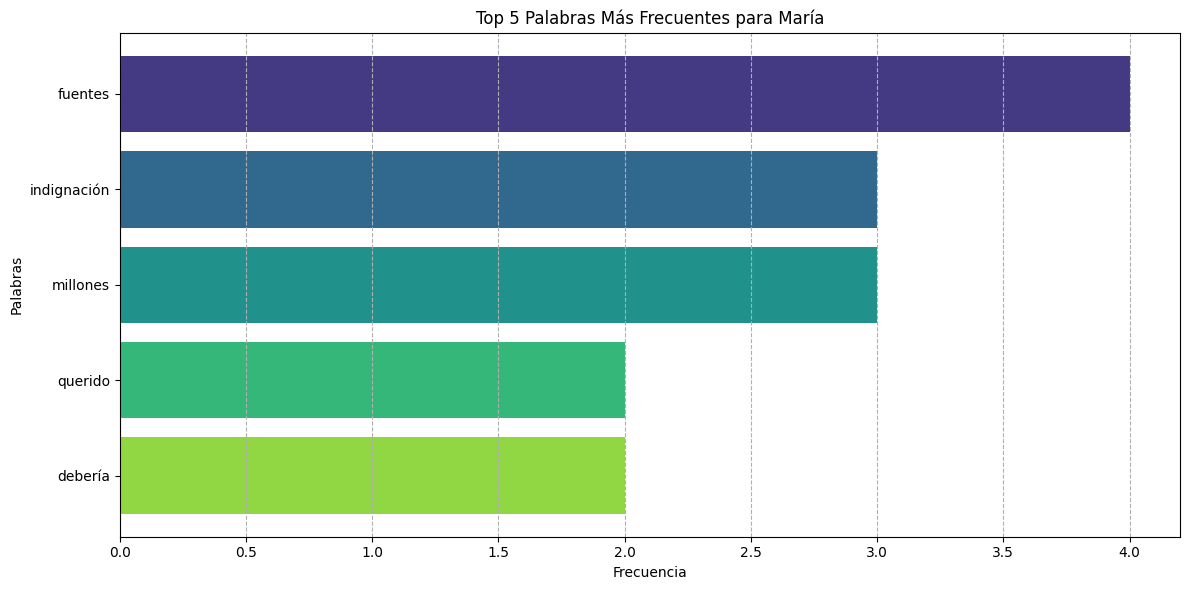

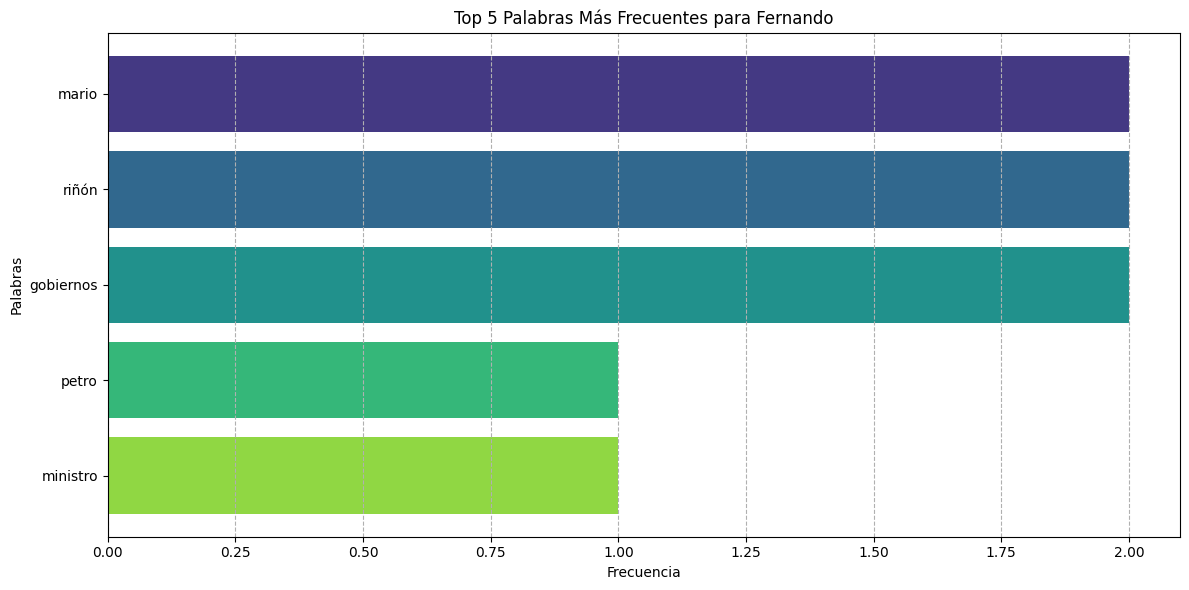

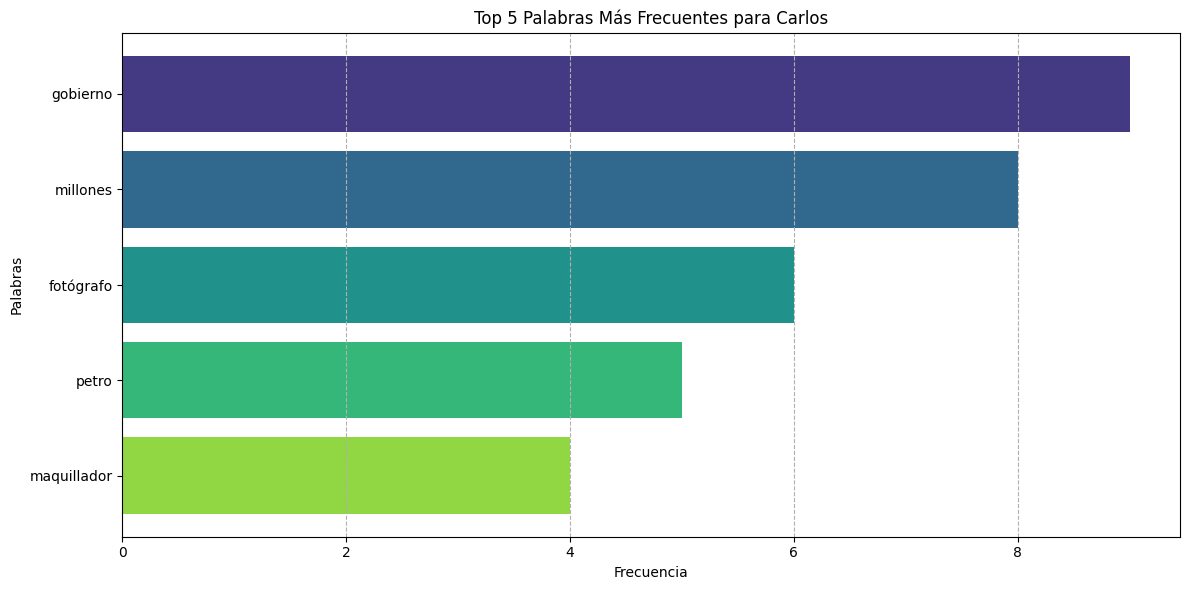

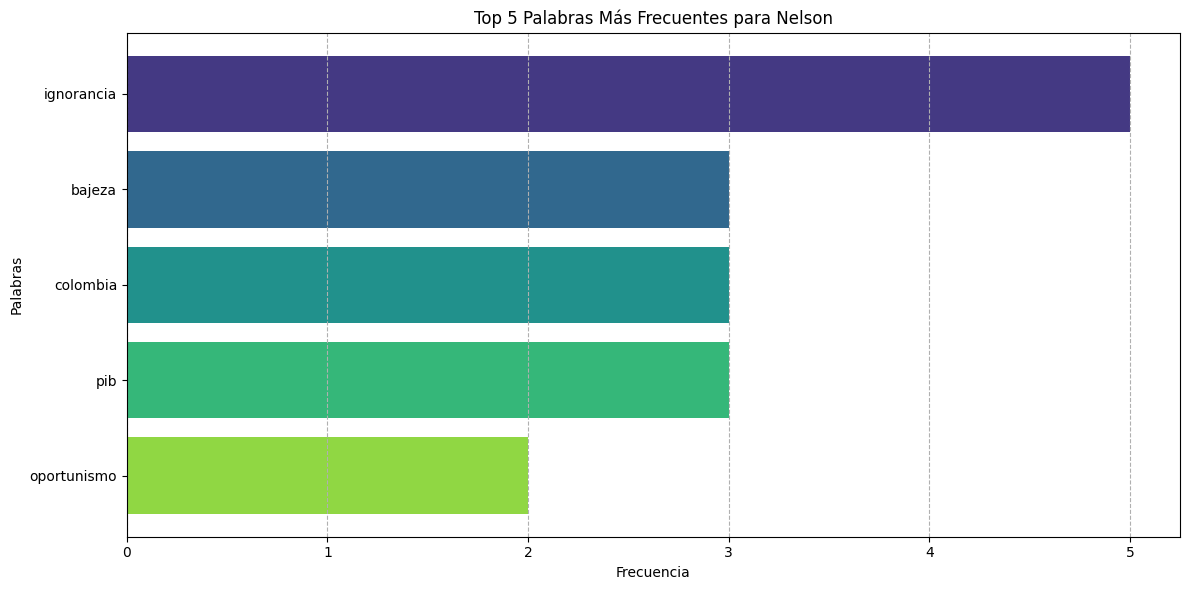

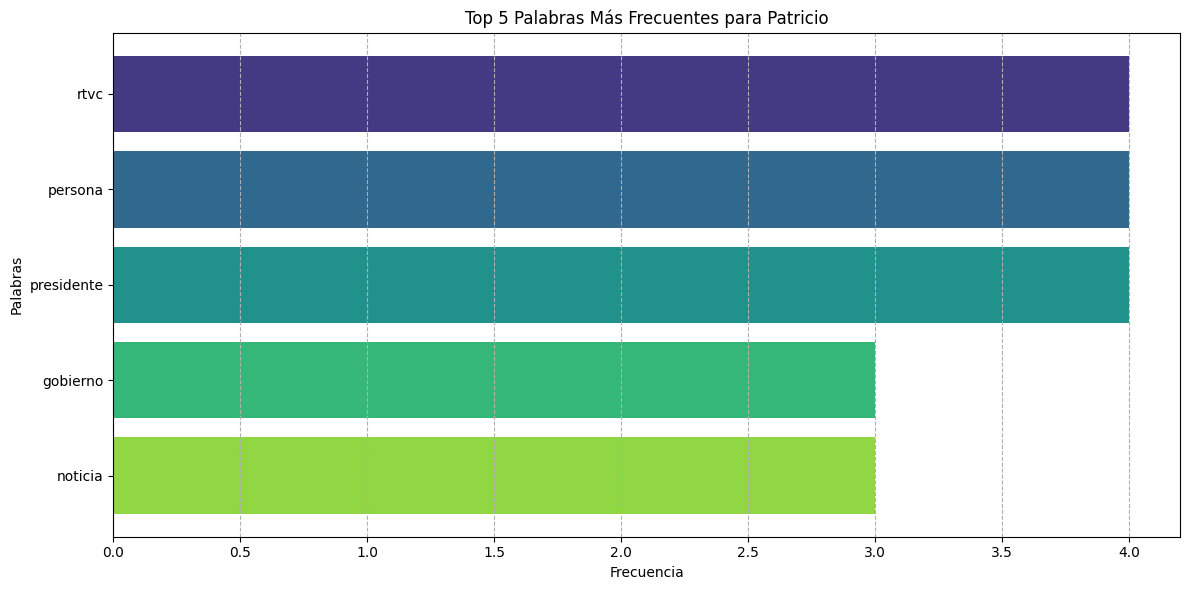

In [17]:
for participant, top_words in participant_top_words.items():
    words = [word for word, freq in top_words]
    frequencies = [freq for word, freq in top_words]

    plt.figure(figsize=(12, 6))
    colors = sns.color_palette('viridis', len(words))
    plt.barh(words, frequencies, color=colors)
    plt.title(f'Top 5 Palabras Más Frecuentes para {participant}')
    plt.xlabel('Frecuencia')
    plt.ylabel('Palabras')
    plt.grid(axis='x', linestyle='--')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

### Hallazgos Principales

El análisis de frecuencia de palabras revela el **carácter político** de la conversación. Los términos más utilizados ("gobierno", "millones", "petro", "rtvc", "fuentes") evidencian una discusión centrada en:

1. **Gestión gubernamental** - críticas y defensas al gobierno actual
2. **Gasto público** - controversias sobre contratos y asignación de recursos
3. **Verificación de información** - debate sobre fuentes confiables vs. desinformación

### Perfiles de Participantes

| Participante | Enfoque Principal | Palabras Clave | Tono Percibido |
|-------------|-------------------|----------------|----------------|
| **Pedro** | Noticias específicas | ministro, bicicleta, murió | Crítico, emotivo |
| **María** | Validación de fuentes | fuentes, indignación, millones | Escéptico, analítico |
| **Fernando** | Casos personales | Mario, riñón | Testimonial |
| **Carlos** | Crítica al gobierno | gobierno, millones, fotógrafo | Opositor activo |
| **Nelson** | Análisis económico-social | ignorancia, bajeza, pib | Opinión fuerte |
| **Patricio** | Defensa gubernamental | presidente, persona, rtvc | Confrontativo |

### Observaciones

- **Polarización evidente**: los participantes se dividen entre críticos y defensores del gobierno.
- **Tema del "fotógrafo"**: aparece en múltiples participantes, sugiriendo una controversia específica sobre contrataciones en medios públicos (RTVC).
- **Uso de cifras**: la palabra "millones" es recurrente, indicando discusiones sobre presupuesto y gasto.
- **Interacción directa**: palabras como "usted" sugieren debates directos entre participantes.

# Análisis de Sentimientos con VADER

En esta sección se aplica análisis de sentimientos a los mensajes del chat utilizando VADER, primero en español y luego traduciendo al inglés para mejorar la precisión. Se visualizan los resultados y se comparan ambos enfoques, evidenciando polarización y diferencias entre participantes. Este proceso permite identificar el tono predominante y la carga emocional de la conversación política.

In [18]:
# Descargar lexicón de VADER
nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

df["scores"] = df["message"].apply(lambda x: sia.polarity_scores(x))
df["compound"] = df["scores"].apply(lambda x: x["compound"])
df["sentiment"] = df["compound"].apply(
    lambda x: "positive" if x > 0.05 else "negative" if x < -0.05 else "neutral"
)

df[["name", "message", "compound", "sentiment"]].head(20)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,name,message,compound,sentiment
0,Pedro,Que par de Joyitas son Petro y el ministro de ...,0.0000,neutral
1,Pedro,Son unos Barbaros,0.0000,neutral
2,Pedro,Que lo diga alguien que votó y celebró el triu...,0.0000,neutral
3,María,Me encantan las fuentes de documentación de lo...,0.0000,neutral
4,Fernando,"Que lo diga petro , pero que lo diga el minist...",-0.5267,negative
5,Pedro,El duo de la Muerte culparon a la Señora Madre...,0.0000,neutral
6,Pedro,"Pues el no murió por la caida en Bicicleta, Mu...",-0.5267,negative
7,Pedro,"Kevin, un niño de 7 años",0.0000,neutral
8,Pedro,"No son fuentes de documentación y pacotilla, s...",-0.2960,negative
9,María,"querido Pedro, la indignación debería sentirla...",0.0000,neutral


Se observan mensajes clasificados como neutrales, aunque son evidentemente negativos. Esto ocurre debido a que VADER utiliza términos en inglés. Aunque no es la mejor aproximación dado que perdemos precisión en el significado, por motivos de prueba realizaremos el análisis realizando una traducción del texto.

In [19]:
from deep_translator import GoogleTranslator

# Función para traducir con manejo de errores
def translate_text(text):
    try:
        # deep_translator tiene límite de 5000 caracteres, truncamos si es necesario
        text_truncated = text[:4500] if len(text) > 4500 else text
        return GoogleTranslator(source='es', target='en').translate(text_truncated)
    except Exception as e:
        return text  # Retornar original si falla

# Traducir mensajes al inglés
print("Traduciendo mensajes...")
df['message_en'] = df['message'].apply(translate_text)
print("Traducción completada!")

# Mostrar primeros 10 mensajes traducidos
df[['name', 'message', 'message_en']].head(10)

Traduciendo mensajes...
Traducción completada!


,name,message,message_en
0,Pedro,Que par de Joyitas son Petro y el ministro de ...,What a pair of Jewels Petro and the Minister o...
1,Pedro,Son unos Barbaros,They are barbarians
2,Pedro,Que lo diga alguien que votó y celebró el triu...,Let someone who voted and celebrated the victo...
3,María,Me encantan las fuentes de documentación de lo...,I love the sources of documentation of those w...
4,Fernando,"Que lo diga petro , pero que lo diga el minist...","Let Petro say it, but let the Minister of Heal..."
5,Pedro,El duo de la Muerte culparon a la Señora Madre...,The duo of Death blamed Lady Mother for lettin...
6,Pedro,"Pues el no murió por la caida en Bicicleta, Mu...","Well, he didn't die from falling on a bicycle,..."
7,Pedro,"Kevin, un niño de 7 años","Kevin, a 7 year old boy"
8,Pedro,"No son fuentes de documentación y pacotilla, s...",They are not sources of documentation and tras...
9,María,"querido Pedro, la indignación debería sentirla...","Dear Pedro, the indignation should be felt by ..."


In [20]:
# Aplicar VADER a los mensajes traducidos
df["scores_en"] = df["message_en"].apply(lambda x: sia.polarity_scores(x) if x else {'compound': 0})
df["compound_en"] = df["scores_en"].apply(lambda x: x["compound"])
df["sentiment_en"] = df["compound_en"].apply(
    lambda x: "positive" if x > 0.05 else "negative" if x < -0.05 else "neutral")

# Mostrar los primeros 10 mensajes traducidos y sus puntajes VADER
df[["name", "message_en", "compound_en", "sentiment_en"]].head(10)

,name,message_en,compound_en,sentiment_en
0,Pedro,What a pair of Jewels Petro and the Minister o...,0.4588,positive
1,Pedro,They are barbarians,0.0000,neutral
2,Pedro,Let someone who voted and celebrated the victo...,0.5719,positive
3,María,I love the sources of documentation of those w...,0.6369,positive
4,Fernando,"Let Petro say it, but let the Minister of Heal...",-0.6808,negative
5,Pedro,The duo of Death blamed Lady Mother for lettin...,-0.7906,negative
6,Pedro,"Well, he didn't die from falling on a bicycle,...",0.2709,positive
7,Pedro,"Kevin, a 7 year old boy",0.0000,neutral
8,Pedro,They are not sources of documentation and tras...,0.0000,neutral
9,María,"Dear Pedro, the indignation should be felt by ...",-0.9413,negative


In [21]:

# Comparación de resultados
print("Comparación VADER - Español vs Traducido:")
print("\nSin traducción (español):")
print(df["sentiment"].value_counts())
print("\nCon traducción (inglés):")
print(df["sentiment_en"].value_counts())

Comparación VADER - Español vs Traducido:

Sin traducción (español):
sentiment
negative    41
neutral     38
positive     5
Name: count, dtype: int64

Con traducción (inglés):
sentiment_en
positive    40
negative    29
neutral     15
Name: count, dtype: int64


Se observa una mejor distribución: no hay predominancia de mensajes neutrales que es lo esperado para un chat en el que se tratan estos temas políticos.

In [22]:
# Sentimiento promedio por participante (con traducción)
sentiment_by_participant = df.groupby("name").agg({
    "compound_en": ["mean", "std", "count"]
}).round(3)
sentiment_by_participant.columns = ["Promedio", "Desv. Estándar", "Mensajes"]
sentiment_by_participant = sentiment_by_participant.sort_values("Promedio")
print("Sentimiento por participante (mensajes traducidos, ordenado de más negativo a más positivo):")
sentiment_by_participant

Sentimiento por participante (mensajes traducidos, ordenado de más negativo a más positivo):


,Promedio,Desv. Estándar,Mensajes
name,,,
Nelson,-0.499,0.353,7
Fernando,-0.452,0.215,3
Pedro,0.038,0.417,10
Patricio,0.045,0.504,12
Carlos,0.135,0.512,39
María,0.268,0.531,13


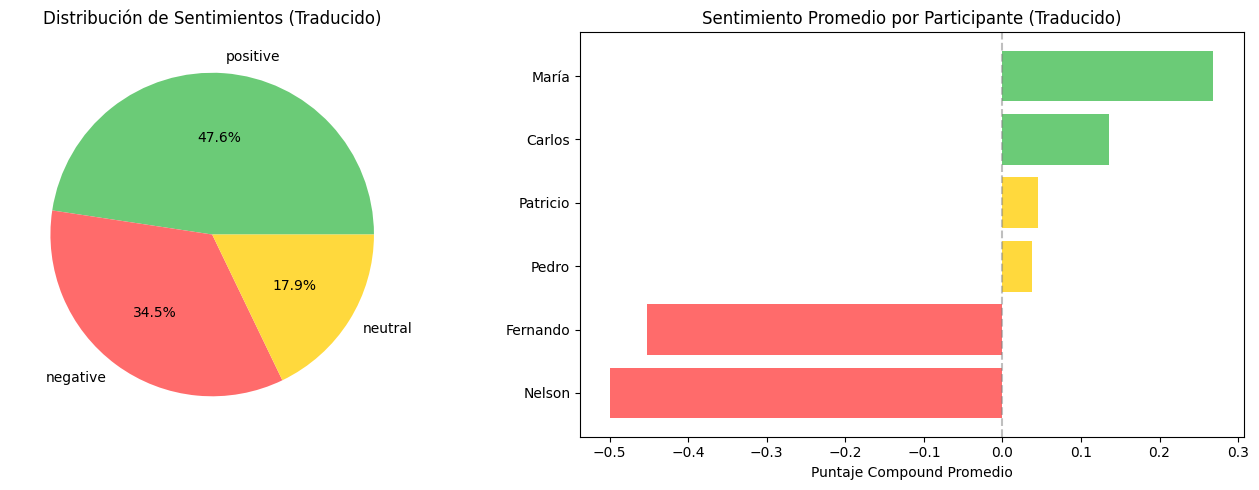

In [23]:
# Visualización de distribución de sentimientos (con traducción)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Distribución de sentimientos (gráfico circular)
colors_pie = {'positive': '#6bcb77', 'neutral': '#ffd93d', 'negative': '#ff6b6b'}
sentiment_counts = df["sentiment_en"].value_counts()
axes[0].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%',
            colors=[colors_pie[s] for s in sentiment_counts.index])
axes[0].set_title("Distribución de Sentimientos (Traducido)")

# Gráfico 2: Compound promedio por participante
sentiment_means = df.groupby("name")["compound_en"].mean().sort_values()
colors_bar = ['#ff6b6b' if x < -0.05 else '#ffd93d' if x <= 0.05 else '#6bcb77' for x in sentiment_means]
axes[1].barh(sentiment_means.index, sentiment_means.values, color=colors_bar)
axes[1].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
axes[1].set_xlabel("Puntaje Compound Promedio")
axes[1].set_title("Sentimiento Promedio por Participante (Traducido)")

plt.tight_layout()
plt.show()

## Resultados

Aunque la traducción mejora los resultados, persisten algunas limitaciones:

- **Pérdida de matices idiomáticos**: expresiones coloquiales colombianas pueden no traducirse bien.
- **Sarcasmo e ironía**: difíciles de preservar en traducción automática y aún con una buena traducción el sarcasmo es difícilmente interpretado por este modelo simple.
- **Contexto cultural**: referencias locales (RTVC, Petro) pueden perder significado.
- **Latencia**: la traducción añade tiempo de procesamiento.

### Hallazgos del Análisis

Los resultados con traducción revelan:
- **Mayor variabilidad** en los scores compound (ya no todo es neutral).
- **Detección de polarización**: se identifican mensajes claramente positivos y negativos, aunque no precisos debido al alto nivel de sarcasmo empleado en el chat.

### Conclusión

El enfoque de **traducción + VADER** es práctico en un entorno académico de análisis de sentimientos en español, pero pierde algunos matices culturales y no se recomienda esta aproximación en un entorno real. Se captura de mejor manera la polaridad general de los mensajes comparado con el tratamiento de los mensajes originales en español y permite identificar patrones de comunicación entre los participantes del chat político analizado.